In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as functional
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/Colab_Notebooks/Faster_R-CNN'

Device: cuda:0
Mounted at /content/drive


In [ ]:
# input variables

img_size = (600, 1000)         # (y,x)
feature_space_size = (19, 32) # (y,x)
# variables to generate the anchor boxes
scales = [4, 8, 10]
ratios = [0.5, 1, 1.5]


In [ ]:
class PennFudanDataset():
    def __init__(self, root):
      self.root = root
      self.transform = transforms.Compose([transforms.Resize(img_size, antialias=True)])
      self.images = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
      self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))


      self.max_objects = 0
      for idx in range(len(self.masks)):
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        mask = read_image(mask_path)
        num_objs = len(torch.unique(mask)[1:])
        if num_objs > self.max_objects:
          self.max_objects = num_objs

      # you have to fill this in yourself with most datasets
      self.object_dict = { 0: 'background', 1: 'person'}


    def getitem(self, idx):
      # load images and masks
      img_path = os.path.join(self.root, "PNGImages", self.images[idx])
      mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

      img = read_image(img_path)

      mask = read_image(mask_path)
      obj_ids = torch.unique(mask)
      # first id is the background, so remove it
      obj_ids = obj_ids[1:]
      # split the color-encoded mask into a set of binary masks
      masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
      # get bounding box coordinates for each mask
      boxes = masks_to_boxes(masks).numpy()

      # put the boxes in the right format [center_x, center_y, width, height]
      ratio_y = img_size[0] / img.shape[1]
      ratio_x = img_size[1] / img.shape[2]
      center_x = boxes[:,0] + 0.5*(boxes[:,2] - boxes[:,0])
      center_y = boxes[:,1] + 0.5*(boxes[:,3] - boxes[:,1])
      width = boxes[:,2] - boxes[:,0]
      height = boxes[:,3] - boxes[:,1]
      boxes = np.stack([center_x*ratio_x, center_y*ratio_y, width*ratio_x, height*ratio_y], axis = -1)

      # resize image with resize
      img = self.transform(img)
      img = np.array(img, dtype=np.int16)/255
      img = img.transpose(1,2,0)

      # there is only one class/label
      labels = np.ones((len(obj_ids),), dtype=np.int8)

      return img, boxes, labels

    def __len__(self):
      return len(self.images)

    def max_num_objects(self):
      return self.max_objects

    def get_label(self, int):
      if int > (len(self.object_dict)-1) | int < (len(self.object_dict)-1):
        return self.object_dict.get(0)
      return self.object_dict.get(int)

    def get_validation_idxs(self):
      return np.arange(0,10)

    def get_train_idxs(self):
      return np.arange(10,len(self.images))

    def unique_labels(self):
      return len(self.object_dict)

In [ ]:
dataset_bodies = PennFudanDataset(os.path.join(root,"PennFudanPed"))

# Accessing the object name for a given number
print(f"size dataset: {len(dataset_bodies)}")
print(f"Object name for number {1}: {dataset_bodies.get_label(1)}")
print(f"unique labels: {dataset_bodies.unique_labels()}")


def plot_with_boxes(image, boxes, labels=None, dataset=None):
  fig, ax = plt.subplots()
  ax.imshow(image)
  for i, box in enumerate(boxes):
    #change the bounding box coordinates from (center_x, center_y, width, height) to (x_min, y_min, width, height)
    box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    if isinstance(labels,np.ndarray):
      plt.text(box[0], box[1], dataset.get_label(labels[i]), color='r')
  ax.set_aspect('equal', adjustable='datalim')
  plt.show()

size dataset: 170
Object name for number 1: person
unique labels: 2


(600, 1000, 3)


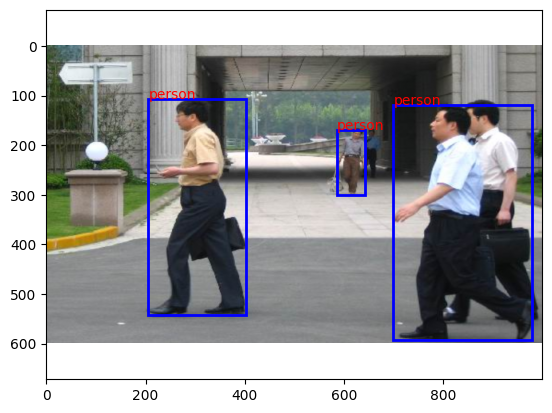

In [ ]:

dataset_bodies = PennFudanDataset(os.path.join(root,"PennFudanPed"))
img, gt_boxes, labels = dataset_bodies.getitem(6)
print(img.shape)

plot_with_boxes(img, gt_boxes, labels, dataset_bodies)

[[ 9.73654938  8.7020998   6.29313564 13.81364727]
 [26.8645649   7.75459385  8.96474934 15.01049805]
 [19.65120506 11.56955433  1.78107619  4.18897629]]


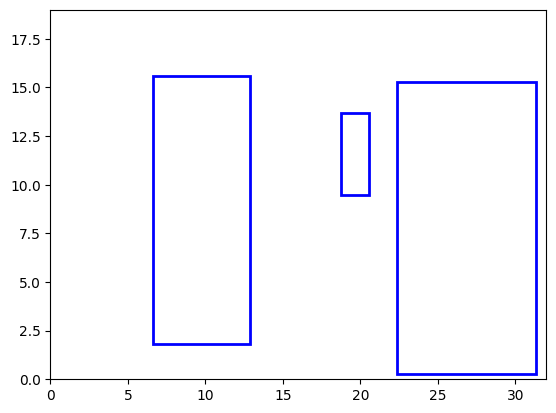

In [ ]:
#boxes in feature space
def change_size(boxes, current_size, target_size):
  ratio_y = target_size[0]/current_size[0]
  ratio_x = target_size[1]/current_size[1]

  if torch.is_tensor(boxes):
    boxes_in_feature_space = torch.zeros(boxes.shape)
  else:
    boxes_in_feature_space = np.zeros(boxes.shape)
  mask = boxes == -1

  boxes_in_feature_space[...,0] = boxes[...,0]* ratio_x                             # center_x
  boxes_in_feature_space[...,2] = boxes[...,2]* ratio_x                             # width
  boxes_in_feature_space[...,3] = boxes[...,3]* ratio_y                             # height
  #change the center of y from top-down to botom-up,
  boxes_in_feature_space[...,1] = target_size[0] - boxes[...,1]*ratio_y   # center_y

  boxes_in_feature_space[mask] = -1
  return boxes_in_feature_space



img, gt_boxes, labels = dataset_bodies.getitem(6)
boxes_in_feature_space = change_size(gt_boxes, img_size, feature_space_size)

# test the coordinates of a picture in feature space
print(boxes_in_feature_space)

fig, ax = plt.subplots()
plt.xlim(0, feature_space_size[1])
plt.ylim(0, feature_space_size[0])
for box in boxes_in_feature_space:
  # change the bounding box coordinates from (center_x, center_y, width, height) to (x_min, y_min, width, height)
  box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')

  ax.add_patch(rect)
plt.show()

(1, 19, 32, 9, 4)
[17.5  9.5  2.   4. ]
[17.5  9.5  4.   4. ]
[17.5  9.5  6.   4. ]
[17.5  9.5  4.   8. ]
[17.5  9.5  8.   8. ]
[17.5  9.5 12.   8. ]
[17.5  9.5  5.  10. ]
[17.5  9.5 10.  10. ]
[17.5  9.5 15.  10. ]


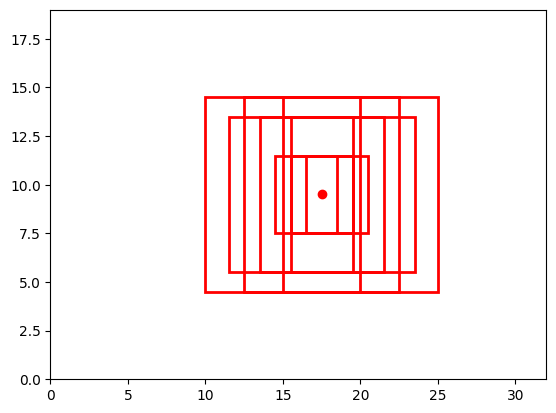

In [ ]:
# generate the anchor boxes
def gen_anchor_points(feature_map_size):
  y_anchor_points = np.flip(np.arange(feature_map_size[0])+0.5, -1)
  x_anchor_points = np.arange(feature_map_size[1])+0.5
  return y_anchor_points, x_anchor_points


def gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, batch_size, feature_space_size):
  num_boxes = len(scales)*len(ratios)
  anchor_boxes_yxyx = np.zeros((y_anchor_points.size, x_anchor_points.size, num_boxes, 4))
  one_set_of_anchor_boxes = np.zeros((num_boxes, 4))

  count = 0
  for scale in scales:
    for ration in ratios:
      h = scale
      w = scale * ration
      one_set_of_anchor_boxes[count] = [-h/2, -w/2, h/2, w/2]
      count += 1

  for i_x, x in enumerate(x_anchor_points):
    for i_y, y in enumerate(y_anchor_points):
      boxes = one_set_of_anchor_boxes+[y, x, y, x]
      anchor_boxes_yxyx[i_y, i_x] = boxes

  botom_inside_img  = anchor_boxes_yxyx[..., 0] > 0
  left_inside_img = anchor_boxes_yxyx[..., 1] > 0
  top_inside_img = anchor_boxes_yxyx[..., 2] < feature_space_size[0]
  right_inside_img = anchor_boxes_yxyx[..., 3] < feature_space_size[1]
  complete_boxes_mask = botom_inside_img * left_inside_img * top_inside_img * right_inside_img

  anchor_boxes_yxyx[..., 0] = np.clip(anchor_boxes_yxyx[..., 0], a_min=0, a_max=feature_space_size[0])
  anchor_boxes_yxyx[..., 1] = np.clip(anchor_boxes_yxyx[..., 1], a_min=0, a_max=feature_space_size[1])
  anchor_boxes_yxyx[..., 2] = np.clip(anchor_boxes_yxyx[..., 2], a_min=0, a_max=feature_space_size[0])
  anchor_boxes_yxyx[..., 3] = np.clip(anchor_boxes_yxyx[..., 3], a_min=0, a_max=feature_space_size[1])

  # put boxes in cxcywh format
  anchor_boxes = np.zeros(anchor_boxes_yxyx.shape)
  anchor_boxes[..., 0] = anchor_boxes_yxyx[...,1] + 0.5*(anchor_boxes_yxyx[...,3] - anchor_boxes_yxyx[...,1])
  anchor_boxes[..., 1] = anchor_boxes_yxyx[...,0] + 0.5*(anchor_boxes_yxyx[...,2] - anchor_boxes_yxyx[...,0])
  anchor_boxes[..., 2] = anchor_boxes_yxyx[...,3] - anchor_boxes_yxyx[...,1]
  anchor_boxes[..., 3] = anchor_boxes_yxyx[...,2] - anchor_boxes_yxyx[...,0]

  anchor_boxes = np.tile(anchor_boxes, (batch_size, 1, 1, 1, 1))
  complete_boxes_mask = np.tile(complete_boxes_mask, (batch_size, 1, 1, 1)).reshape(batch_size, -1)
  return anchor_boxes, complete_boxes_mask


y_anchor_points, x_anchor_points = gen_anchor_points(feature_space_size)
anchor_boxes, _ = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, 1, feature_space_size)
print(anchor_boxes.shape)

# test if the boxes are right
fig, ax = plt.subplots()
plt.xlim(0, feature_space_size[1])
plt.ylim(0, feature_space_size[0])
for box in anchor_boxes[0, 9, 17]:
  print(box)
  # change the bounding box coordinates from (center_x, center_y, width, height) to (x_min, y_min, width, height)
  box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')

  ax.add_patch(rect)
plt.scatter(17.5,9.5, color='red', label='New Point')
plt.show()

shape GT boxes: (1, 3, 4)
shape anchor boxes: (1, 19, 32, 9, 4)
shape IOU matix: (1, 5472, 3)
 higest IOUs per anchor box: [[0.         0.         0.         ... 0.08881908 0.18261021 0.27556606]]
 higest IOUs per GT box: [[0.57516778 0.62701581 0.81816759]]
indexes(flattened) of anchor boxes with the most overlap with the GT boxes: [2187 2391 2679 2842 2967 3130 3255 3418 3706 3994]


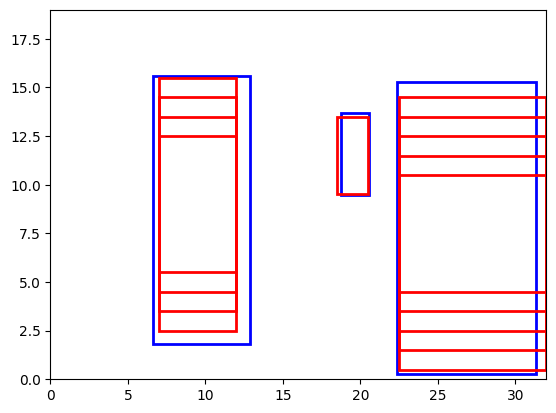

In [ ]:
# Helper functions
def from_cxcywh_to_yxyx(coordinates):
  #coordinates_yxyx = np.zeros(coordinates.shape)
  mask = coordinates == -1

  center_x = coordinates[..., 0]
  center_y = coordinates[..., 1]
  width = coordinates[..., 2]
  height = coordinates[..., 3]

  y_min = center_y - 0.5 * height
  x_min = center_x - 0.5 * width
  y_max = center_y + 0.5 * height
  x_max = center_x + 0.5 * width

  coordinates_yxyx = np.stack([y_min, x_min, y_max, x_max], axis = -1)
  coordinates_yxyx[mask] = -1
  return coordinates_yxyx


def from_cxcywh_to_xyxy(coordinates):
  center_x = coordinates[..., 0]
  center_y = coordinates[..., 1]
  width = coordinates[..., 2]
  height = coordinates[..., 3]
  x_min = center_x - 0.5 * width
  y_min = center_y - 0.5 * height
  x_max = center_x + 0.5 * width
  y_max = center_y + 0.5 * height

  if torch.is_tensor(coordinates):
    coordinates_xyxy = torch.stack([x_min, y_min, x_max, y_max], axis = -1)
  else:
    coordinates_xyxy = np.stack([x_min, y_min, x_max, y_max], axis = -1)
  return coordinates_xyxy

# Use numpy.vectorize to calculate IoU matrix for all pairs of bounding boxes
def calculate_iou(anchor_boxes, GT_boxes):
  assert GT_boxes.shape[0] == anchor_boxes.shape[0], "Batch sizes are not the same!"
  anchor_boxes = from_cxcywh_to_yxyx(anchor_boxes)
  GT_boxes = from_cxcywh_to_yxyx(GT_boxes)

  def one_iou(box1, box2):
    # Calculate the intersection area
    x_min = np.maximum(box1[1], box2[1])
    y_min = np.maximum(box1[0], box2[0])
    x_max = np.minimum(box1[3], box2[3])
    y_max = np.minimum(box1[2], box2[2])
    intersection_area = np.maximum(0, x_max - x_min) * np.maximum(0, y_max - y_min)

    # Calculate the union area
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = (box1_area + box2_area) - intersection_area

    # Calculate the IoU score
    iou = intersection_area/union_area
    return iou

  v_calculate_iou = np.vectorize(one_iou, signature='(n),(m)->()')
  anchor_boxes = anchor_boxes.reshape(anchor_boxes.shape[0], -1, 4)

  iou_matrix = []
  for batch in range(GT_boxes.shape[0]):
    anchor_boxes_batch = anchor_boxes[batch]
    GT_boxes_batch = GT_boxes[batch]
    iou_matrix.append(v_calculate_iou(np.expand_dims(anchor_boxes_batch, axis=-2), GT_boxes_batch))
  iou_matrix = np.stack(iou_matrix, axis=0)
  return iou_matrix

y_anchor_points, x_anchor_points = gen_anchor_points(feature_space_size)
anchor_boxes,_ = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, 1, feature_space_size)
img, gt_boxes, labels = dataset_bodies.getitem(6)

gt_boxes = change_size(gt_boxes, img_size, feature_space_size)
gt_boxes = np.expand_dims(gt_boxes, axis=-3)
print(f"shape GT boxes: {gt_boxes.shape}")
print(f"shape anchor boxes: {anchor_boxes.shape}")


#IOU
iou = calculate_iou(anchor_boxes, gt_boxes)
print(f"shape IOU matix: {iou.shape}")

# the max values
max_iou_per_anchor_box = np.max(iou, axis=-1)
max_iou_per_GT_box = np.max(iou, axis=1)
print(f" higest IOUs per anchor box: {max_iou_per_anchor_box}")
print(f" higest IOUs per GT box: {max_iou_per_GT_box}")


#get the indexes of the max iou per GT box
max_iou_per_GT_box = max_iou_per_GT_box[max_iou_per_GT_box != 0]
mask = np.isin(iou, max_iou_per_GT_box)

idxs = np.squeeze(np.where(np.max(mask, axis=-1).reshape((-1))))
print(f"indexes(flattened) of anchor boxes with the most overlap with the GT boxes: {idxs}")


# test if the IOU works, and it does!
gt_boxes = gt_boxes.reshape( -1, 4)
anchor_boxes = anchor_boxes.reshape( -1, 4)

fig, ax = plt.subplots()
plt.xlim(0, feature_space_size[1])
plt.ylim(0, feature_space_size[0])
for box in gt_boxes:
  # change the bounding box coordinates from (center_x, center_y, width, height) to (x_min, y_min, width, height)
  box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
  ax.add_patch(rect)
for idx in idxs:
  box = [anchor_boxes[idx][0]-0.5*anchor_boxes[idx][2], anchor_boxes[idx][1]-0.5*anchor_boxes[idx][3], anchor_boxes[idx][2], anchor_boxes[idx][3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

In [ ]:
# formulas to calculate and apply the offsets
def calc_gt_offsets(anchor_boxes, gt_boxes):
  assert anchor_boxes.shape == gt_boxes.shape, "not the same shape!"

  gt_cx, gt_cy, gt_w, gt_h = gt_boxes[:, 0], gt_boxes[:, 1], gt_boxes[:, 2], gt_boxes[:, 3]
  anc_cx, anc_cy, anc_w, anc_h = anchor_boxes[:, 0], anchor_boxes[:, 1], anchor_boxes[:, 2], anchor_boxes[:, 3]
  offset_x = (gt_cx - anc_cx)/anc_w
  offset_y = (gt_cy - anc_cy)/anc_h
  offset_width = np.log(gt_w / anc_w)
  offset_height = np.log(gt_h / anc_h)

  return np.stack([offset_x, offset_y, offset_width, offset_height], axis = -1)


def apply_offsets(boxes, offsets):
  if torch.is_tensor(boxes):
    assert boxes.size() == offsets.size(), "not the same shape!"
  else:
    assert boxes.shape == offsets.shape, "not the same shape!"

  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  offset_x, offset_y, offset_w, offset_h = offsets[:, 0], offsets[:, 1], offsets[:, 2], offsets[:, 3]
  center_x = cx + (w * offset_x)
  center_y = cy + (h * offset_y)
  if torch.is_tensor(boxes):
    width = w * torch.exp(offset_w)
    height = h * torch.exp(offset_h)
  else:
    width = w * np.exp(offset_w)
    height = h * np.exp(offset_h)

  if torch.is_tensor(boxes):
    boxes = torch.stack([center_x, center_y, width, height], axis = -1)
  else:
    boxes = np.stack([center_x, center_y, width, height], axis = -1)
  return boxes

In [ ]:
def get_target_data(anchor_boxes, GT_boxes, GT_labels, complete_boxes_mask, pos_threshold=0.70, neg_threshold=0.30):

  iou = calculate_iou(anchor_boxes, GT_boxes)

  batch_size = iou.shape[0]
  no_anchor_boxes = iou.shape[1]

  # the max values
  max_iou_per_anchor_box = np.max(iou, axis=-1)
  max_iou_per_GT_box = np.max(iou, axis=1)

  # positive anchor idxs
  # mask based on threshold
  iou[np.where(complete_boxes_mask ==False)]=0
  mask_1 = iou > pos_threshold
  # mask based on the max iou per GT_box
  max_values = np.max(iou, axis=1)
  max_values = max_values[max_values != 0]
  mask_2 = np.isin(iou, max_values)
  threshold_mask =mask_1 + mask_2
  # exclude negative values
  negative_check = iou > 0
  threshold_mask =  threshold_mask*negative_check
  threshold_mask = np.max(threshold_mask, axis=-1)
  threshold_mask = threshold_mask

  #positiev anchor indxs
  positive_anchor_idxs_per_batch = np.where(threshold_mask)
  threshold_mask = threshold_mask.reshape((-1))
  positive_anchor_idxs = np.where(threshold_mask)

  # GT confidence scores
  #GT_confidence_scores = max_iou_per_anchor_box.reshape((-1))[positive_anchor_idxs]

  # GT_labels
  GT_labels_expanded = np.repeat(GT_labels[:, np.newaxis, :], no_anchor_boxes, axis=1)
  GT_labels_expanded = GT_labels_expanded.reshape((-1, iou.shape[-1]))
  class_per_box = np.argmax(iou.reshape((-1, iou.shape[-1])), axis=-1)

  GT_labels = GT_labels_expanded[np.arange(GT_labels_expanded.shape[0]), class_per_box][positive_anchor_idxs]
  #print(GT_labels.shape)


  # GT_bboxes
  GT_boxes_expanded = np.repeat(GT_boxes[:, np.newaxis, :], no_anchor_boxes, axis=1)
  GT_boxes_expanded = GT_boxes_expanded.reshape((-1, iou.shape[-1], 4))
  GT_boxes = GT_boxes_expanded[np.arange(GT_boxes_expanded.shape[0]), class_per_box][positive_anchor_idxs]
  #print(GT_boxes.shape)

  # positive anchor coordinates
  positive_anchor_boxes = anchor_boxes.reshape((-1, 4))[positive_anchor_idxs]

  # GT_offsets
  GT_offsets = calc_gt_offsets(positive_anchor_boxes, GT_boxes.reshape((-1, 4)))
  #print(GT_offsets.shape)

  # negative anchor idxs & boxes
  negative_mask = iou < neg_threshold
  negative_mask = np.min(negative_mask, axis=-1) * complete_boxes_mask
  negative_anchor_idxs_per_batch = np.where(negative_mask)
  negative_mask = negative_mask.reshape((-1))
  negative_anchor_idxs = np.where(negative_mask)
  negative_anchor_boxes = anchor_boxes.reshape((batch_size, -1, 4))[negative_anchor_idxs_per_batch]

  multiplier = 2
  negative_anchor_idxs = negative_anchor_idxs[0][np.random.randint(0, negative_anchor_idxs[0].shape[0], size=(positive_anchor_boxes.shape[0]*multiplier))]

  gt_and_backgroud_boxes_per_img = []
  gt_and_backgroud_labels = np.array([])
  for idx in range(batch_size):
    #positives
    pos_proposal_idxs = np.where(positive_anchor_idxs_per_batch[0] == idx)
    #GT_boxes_per_img = positive_anchor_boxes[pos_proposal_idxs]
    GT_boxes_per_img = GT_boxes[pos_proposal_idxs]

    GT_labels_per_img = GT_labels[pos_proposal_idxs]

    #negatives
    neg_proposal_idxs = np.where(negative_anchor_idxs_per_batch[0] == idx)
    backgroud_boxes_per_img = negative_anchor_boxes[neg_proposal_idxs]
    backgroud_boxes_per_img = backgroud_boxes_per_img[np.random.randint(0, backgroud_boxes_per_img.shape[0], size=(GT_boxes_per_img.shape[0]*multiplier))]
    background_labels = np.zeros((len(GT_labels_per_img)*multiplier), dtype=np.int8)

    #append
    gt_and_backgroud_labels = np.append(gt_and_backgroud_labels, GT_labels_per_img)
    gt_and_backgroud_labels = np.append(gt_and_backgroud_labels, background_labels)
    tmp = np.concatenate((GT_boxes_per_img, backgroud_boxes_per_img), axis=0)
    gt_and_backgroud_boxes_per_img.append(tmp)

  return positive_anchor_idxs, negative_anchor_idxs, positive_anchor_boxes, gt_and_backgroud_boxes_per_img, gt_and_backgroud_labels, GT_offsets, GT_labels, GT_boxes


[array([[26.4720211 ,  7.83206177,  9.34306622, 13.73027897],
       [26.4720211 ,  7.83206177,  9.34306622, 13.73027897],
       [26.4720211 ,  7.83206177,  9.34306622, 13.73027897],
       [26.4720211 ,  7.83206177,  9.34306622, 13.73027897],
       [ 9.5       , 11.5       , 15.        , 10.        ],
       [27.5       ,  5.5       ,  6.        ,  4.        ],
       [20.5       , 11.5       ,  6.        ,  4.        ],
       [ 8.5       , 11.5       , 15.        , 10.        ],
       [17.5       ,  8.5       ,  2.        ,  4.        ],
       [16.5       ,  6.5       ,  8.        ,  8.        ],
       [21.5       , 14.5       ,  4.        ,  8.        ],
       [16.5       , 10.5       ,  6.        ,  4.        ]])]
12


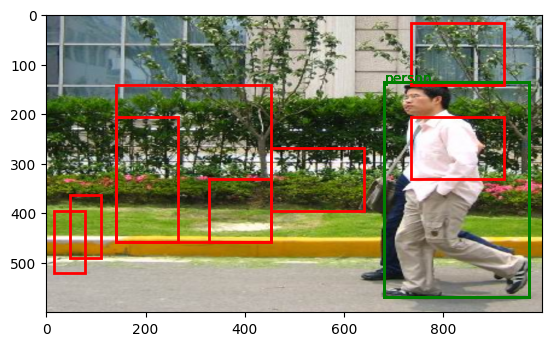

In [ ]:
y_anchor_points, x_anchor_points = gen_anchor_points(feature_space_size)
anchor_boxes, complete_boxes_mask = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, 1, feature_space_size)

img, gt_boxes, labels = dataset_bodies.getitem(9)
gt_boxes = np.expand_dims(gt_boxes, axis=-3)
gt_boxes = change_size(gt_boxes, img_size, feature_space_size)
labels = np.expand_dims(labels, axis=-2)

positive_anchor_idxs, negative_anchor_idxs, positive_anchor_boxes, gt_and_backgroud_boxes_per_img, gt_and_backgroud_labels, GT_offsets, GT_labels, GT_boxes = get_target_data(anchor_boxes, gt_boxes, labels, complete_boxes_mask)
print(gt_and_backgroud_boxes_per_img)
print(len(gt_and_backgroud_labels))

# test if the get_target_data function works, and it does:
gt_boxes = change_size(gt_boxes.reshape( -1, 4), feature_space_size, img_size)

positive_anchor_boxes = change_size(apply_offsets(positive_anchor_boxes, GT_offsets), feature_space_size, img_size)
#positive_anchor_boxes = change_size(positive_anchor_boxes, feature_space_size, img_size)
negative_anchor_boxes = change_size(anchor_boxes.reshape( -1, 4)[negative_anchor_idxs], feature_space_size, img_size)



# These are the positive anchor boxes (after appliying the offsets) and the negative achor boxes in image space,
# and the ground truth boxes(but you cant see them becaue they are behind the positive anchor boxes)
fig, ax = plt.subplots()
ax.imshow(img)
for box in gt_boxes:
  # change the bounding box coordinates from (center_x, center_y, width, height) to (x_min, y_min, width, height)
  box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
  ax.add_patch(rect)
for box, Class in zip(positive_anchor_boxes, GT_labels):
  box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='g', facecolor='none')
  ax.add_patch(rect)
  plt.text(box[0], box[1], dataset_bodies.get_label(Class), color='g')
for box in negative_anchor_boxes:
  box = [box[0]-0.5*box[2], box[1]-0.5*box[3], box[2], box[3]]
  rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)


Neural Network

In [ ]:
# the backbone neural network
from torchsummary import summary
from torchvision.models import MobileNet_V3_Large_Weights
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models import mobilenet_v3_large

#backbone
backbone = mobilenet_v3_large(MobileNet_V3_Large_Weights.IMAGENET1K_V2).features

stage_indices = [0] + [i for i, b in enumerate(backbone) if getattr(b, "_is_cn", False)] + [len(backbone) - 1]
print(stage_indices)
num_stages = len(stage_indices)
print(num_stages)

freeze_before = stage_indices[num_stages -3]
for b in backbone[:freeze_before]:
  for parameter in b.parameters():
    parameter.requires_grad_(False)

out_channels = 256

backbone.to(device)
summary(backbone, input_size=(3, img_size[0], img_size[1]))

extra_blocks = LastLevelMaxPool()
returned_layers = [num_stages - 2, num_stages - 1]
return_layers = {f"{stage_indices[k]}": str(v) for v, k in enumerate(returned_layers)}
print(return_layers)
in_channels_list = [backbone[stage_indices[i]].out_channels for i in returned_layers]
print(in_channels_list)

backbone = BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels,extra_blocks=extra_blocks, norm_layer=None).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


[0, 2, 4, 7, 13, 16]
6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 300, 500]             432
       BatchNorm2d-2         [-1, 16, 300, 500]              32
         Hardswish-3         [-1, 16, 300, 500]               0
            Conv2d-4         [-1, 16, 300, 500]             144
       BatchNorm2d-5         [-1, 16, 300, 500]              32
              ReLU-6         [-1, 16, 300, 500]               0
            Conv2d-7         [-1, 16, 300, 500]             256
       BatchNorm2d-8         [-1, 16, 300, 500]              32
  InvertedResidual-9         [-1, 16, 300, 500]               0
           Conv2d-10         [-1, 64, 300, 500]           1,024
      BatchNorm2d-11         [-1, 64, 300, 500]             128
             ReLU-12         [-1, 64, 300, 500]               0
           Conv2d-13         [-1, 64, 150, 250]             576
      BatchNorm2

In [ ]:
# test the MultiScaleRoIAlign
from torchvision.ops import MultiScaleRoIAlign

box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "pool"], output_size=7, sampling_ratio=2)

anchor_boxes, complete_boxes_mask = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, 1, feature_space_size)
img, gt_boxes, labels = dataset_bodies.getitem(9)
gt_boxes = np.expand_dims(gt_boxes, axis=-3)
gt_boxes = change_size(gt_boxes, img_size, feature_space_size)
labels = np.expand_dims(labels, axis=-2)
positive_anchor_idxs, negative_anchor_idxs, positive_anchor_boxes, gt_and_backgroud_boxes_per_img, gt_and_backgroud_labels, GT_offsets, GT_labels, GT_boxes = get_target_data(anchor_boxes, gt_boxes, labels, complete_boxes_mask)

classification_boxes = []
for boxes_per_img in gt_and_backgroud_boxes_per_img:
    boxes_per_img = change_size(boxes_per_img, feature_space_size, img_size)
    boxes_per_img = from_cxcywh_to_xyxy(boxes_per_img)
    boxes_per_img = torch.from_numpy(boxes_per_img).to(dtype=torch.float32).to(device)
    boxes_per_img.requires_grad_(False)
    classification_boxes.append(boxes_per_img)

img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.permute(2, 0, 1)
img_tensor = torch.unsqueeze(img_tensor, 0).to(dtype=torch.float32).to(device)


feature_space = backbone(img_tensor)
print('out layers of the backbone:')
for name in feature_space:
  print(name)
  print(feature_space[name].size())

print('tensor with the boxes (xyxy):')
print(classification_boxes)

box_features = box_roi_pool(feature_space, classification_boxes, [img_size])
print('out layers of box_roi_pool with 8 boxes to be classified:')
print(box_features.size())

out layers of the backbone:
0
torch.Size([1, 256, 19, 32])
1
torch.Size([1, 256, 19, 32])
pool
torch.Size([1, 256, 10, 16])
tensor with the boxes (xyxy):
[tensor([[681.2653, 135.8779, 973.2361, 569.4656],
        [681.2653, 135.8779, 973.2361, 569.4656],
        [681.2653, 135.8779, 973.2361, 569.4656],
        [681.2653, 135.8779, 973.2361, 569.4656],
        [578.1250, 300.0000, 640.6250, 426.3158],
        [421.8750,  15.7895, 734.3750, 331.5789],
        [546.8750, 110.5263, 796.8750, 363.1579],
        [265.6250, 142.1053, 328.1250, 268.4211],
        [ 15.6250,  15.7895, 140.6250, 268.4211],
        [296.8750, 110.5263, 421.8750, 363.1579],
        [578.1250, 142.1053, 703.1250, 394.7368],
        [375.0000, 268.4211, 843.7500, 584.2105]], device='cuda:0')]
out layers of box_roi_pool with 8 boxes to be classified:
torch.Size([12, 256, 7, 7])


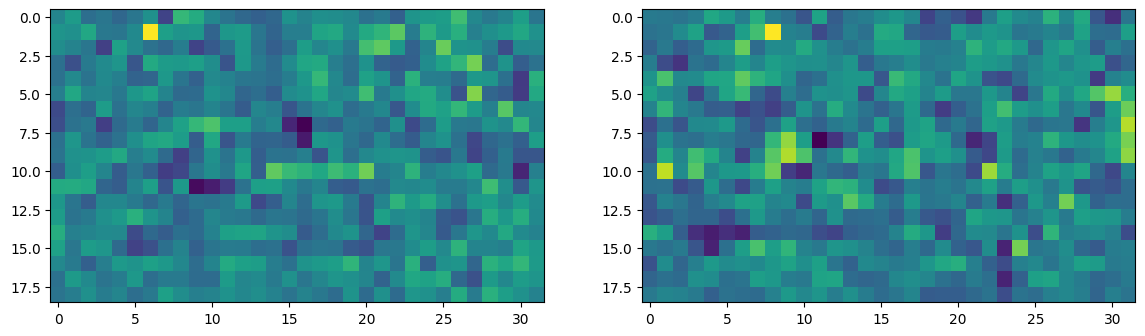

In [ ]:
nrows, ncols = (1, 2)
fig, ax = plt.subplots(nrows, ncols, figsize=(14, 6))

filters =[feature_space['1'][0, i].cpu().detach().numpy() for i in range(2)]

for i, data in enumerate(filters):
  ax[i].imshow(data)

In [ ]:
# loss functions for the Boundry boxes
def calc_confidence_loss(confidence_scores, positive_anchor_idxs):
  positives = torch.ones(positive_anchor_idxs.size(0), dtype=torch.float64).to(device)
  negatives = torch.zeros((confidence_scores.size(0) - positive_anchor_idxs.size(0)), dtype=torch.float64).to(device)
  targets = torch.cat((positives, negatives))
  return functional.binary_cross_entropy_with_logits(confidence_scores, targets)#/batch_size

def calc_offset_loss(proposed_offsets, GT_offsets, sampled_inds):
  return functional.smooth_l1_loss(proposed_offsets, GT_offsets, beta=8/9, reduction='sum')/(sampled_inds.numel())

In [ ]:
# the neural nets for the boudry boxes ans the classification
class box_nn(nn.Module):
  def __init__(self, num_anchor_boxes, backbone=backbone, out_channels=out_channels):
    super().__init__()

    self.anchor_boxes_per_point = num_anchor_boxes
    self.backbone = backbone
    self.hidden_layer = ops.Conv2dNormActivation(out_channels, out_channels, kernel_size=3, norm_layer=None)
    self.confidence_head = nn.Conv2d(out_channels, num_anchor_boxes, kernel_size=1)
    self.offset_head = nn.Conv2d(out_channels, num_anchor_boxes*4, kernel_size=1)

    for layer in [self.hidden_layer, self.confidence_head, self.offset_head]:
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01)
                if layer.bias is not None:
                    torch.nn.init.constant_(layer.bias, 0)


  def forward(self, images):
    feature_space = self.backbone(images)
    hidden_layers = self.hidden_layer(feature_space['1'])
    hidden_layers = functional.relu(hidden_layers)
    confidence_scores = self.confidence_head(hidden_layers)

    batch_size = confidence_scores.size(0)
    confidence_scores = confidence_scores.permute(0, 2, 3, 1)
    confidence_scores = confidence_scores.reshape(batch_size, -1)

    offsets =self.offset_head(hidden_layers)
    offsets = offsets.permute(0, 2, 3, 1)
    offsets = offsets.reshape(batch_size, -1, 4)

    return confidence_scores, offsets, feature_space


class classification_nn(nn.Module):
  def __init__(self, n_labels, out_channels=out_channels):
    super().__init__()

    output_size=7
    self.box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "pool"], output_size=output_size, sampling_ratio=2)
    self.representation_size = 1024
    self.linear = nn.Linear(out_channels * output_size**2, self.representation_size)
    self.class_head = nn.Linear(self.representation_size, n_labels)

  def forward(self, feature_space, box_proposals_per_img, img_sizes):

    box_features = self.box_roi_pool(feature_space, box_proposals_per_img, img_sizes)
    x = box_features.flatten(start_dim=1)
    x = functional.relu(self.linear(x))
    x = x.flatten(start_dim=1)
    class_predictions = self.class_head(x)
    return class_predictions

In [ ]:
class box_module(nn.Module):
  def __init__(self, scales, ratios):
    super().__init__()

    self.box_nn = box_nn(len(scales)*len(ratios))

  def forward(self, images, anchor_boxes, train=False, positive_anchor_idxs=None, negative_anchor_idxs=None, GT_offsets=None):
    batch_size = images.size(0)
    confidence_scores, offsets, feature_space = self.box_nn.forward(images)

    if train:
      confidence_scores =  confidence_scores.reshape(-1)
      sampled_inds = torch.cat([positive_anchor_idxs, negative_anchor_idxs], dim=0)
      confidence_scores = confidence_scores[sampled_inds]
      proposed_offsets = offsets.reshape(-1, 4)[positive_anchor_idxs]


      #loss
      confidence_loss = calc_confidence_loss(confidence_scores, positive_anchor_idxs)
      offset_loss = calc_offset_loss(proposed_offsets, GT_offsets, sampled_inds)
      return confidence_loss, offset_loss, feature_space

    else:
      anchor_boxes = anchor_boxes.reshape(batch_size, -1, 4)

      confidence_scores = torch.sigmoid(confidence_scores)
      box_proposals = []
      confidences = []

      for i in range(batch_size):
        _, top_indices = torch.topk(confidence_scores[i], k=40)
        #top_indices = torch.where(confidence_scores[i,:] > 8.90)
        anchor_boxes_img = anchor_boxes[i][top_indices]
        offsets_img = offsets[i][top_indices]
        confidences_img = confidence_scores[i][top_indices]

        #box_proposals_img = anchor_boxes_img
        box_proposals_img = apply_offsets(anchor_boxes_img, offsets_img)

        # ops.nms needs bounding boxes of shape (N, 4) [x_min, y_min, x_max, y_max] (the shape I use is [center_x, center_y, width, height][y_min, x_min, y_max, x_max])
        box_proposals_for_nms = from_cxcywh_to_xyxy(box_proposals_img)
        nms_idxs = ops.nms(box_proposals_for_nms, confidences_img, 0.5)
        box_proposals.append(box_proposals_img[nms_idxs])
        confidences.append(confidences_img[nms_idxs])
      return box_proposals, confidences, feature_space


class classification_module(nn.Module):
  def __init__(self, n_labels):
    super().__init__()
    self.classification_nn = classification_nn(n_labels)

  def forward(self, feature_space, box_proposals_per_img, img_sizes, train = False, gt_and_backgroud_labels = None):

    class_predictions = self.classification_nn.forward(feature_space, box_proposals_per_img, img_sizes)

    if train:
      return functional.cross_entropy(class_predictions, gt_and_backgroud_labels.long())

    else:
      class_predictions = torch.softmax(class_predictions, dim=-1)[:,1:]
      class_predictions_per_img =[]
      c = 0
      for i in range(len(box_proposals_per_img)):
        num_proposals = len(box_proposals_per_img[i])
        class_predictions_per_img.append(class_predictions[c: c+num_proposals])
        c += num_proposals

      return class_predictions_per_img

In [ ]:
class full_object_detection_model(nn.Module):
  def __init__(self, scales, ratios, n_labels):
    super().__init__()
    self.box_module = box_module(scales, ratios)
    self.classification_module = classification_module(n_labels)
    self.w_confidence_loss = 1
    self.w_offset_loss = 10
    self.w_classification_loss = 1
    self.n_labels = n_labels
  def forward(self, images, anchor_boxes, train=False, positive_anchor_idxs=None, negative_anchor_idxs=None, GT_offsets=None, gt_and_backgroud_boxes_per_img=None, gt_and_backgroud_labels=None):

    if train:
      confidence_loss, offset_loss, feature_space = self.box_module.forward(images, anchor_boxes, True, positive_anchor_idxs, negative_anchor_idxs, GT_offsets)

      #classification with  MultiScaleRoIAlign needs boxes in the xyxy format
      classification_boxes = []
      for boxes_per_img in gt_and_backgroud_boxes_per_img:
          boxes_per_img = change_size(boxes_per_img, feature_space_size, img_size)
          boxes_per_img = torch.from_numpy(boxes_per_img).to(dtype=torch.float32).to(device)
          boxes_per_img.requires_grad_(False)
          boxes_per_img = from_cxcywh_to_xyxy(boxes_per_img)
          classification_boxes.append(boxes_per_img)
      img_sizes = [img_size for i in range(len(classification_boxes))]

      classification_loss = self.classification_module.forward(feature_space, classification_boxes, img_sizes, True, gt_and_backgroud_labels)

      print('confidence_loss: %f' %(self.w_confidence_loss*confidence_loss).item())
      print('offset_loss: %f' %(self.w_offset_loss*offset_loss).item())
      print('label_loss: %f' %(self.w_classification_loss*classification_loss).item())
      total_loss = self.w_confidence_loss*confidence_loss + self.w_offset_loss*offset_loss + self.w_classification_loss*classification_loss
      return total_loss

    else:
      with torch.no_grad():
        box_proposals_per_img, confidences, feature_space = self.box_module.forward(images, anchor_boxes)

        xyxy_box_proposals_per_img = []
        for boxes_per_img in box_proposals_per_img:
          boxes_per_img = change_size(boxes_per_img, feature_space_size, img_size)
          boxes_per_img = from_cxcywh_to_xyxy(boxes_per_img)
          xyxy_box_proposals_per_img.append(boxes_per_img.to(device))

        img_sizes = [img_size for i in range(len(box_proposals_per_img))]
        class_predictions_per_image = self.classification_module.forward(feature_space, xyxy_box_proposals_per_img, img_sizes)

        for i in range(len(class_predictions_per_image)):
          tmp_boxes = torch.tensor([]).to(device)
          tmp_labels = torch.tensor([]).to(device)
          for j in range(self.n_labels-1):
            not_background = (class_predictions_per_image[i][:, j] > 0.90)

            indices = torch.nonzero(not_background).squeeze()
            if indices.dim() == 0:
              tmp_boxes = torch.cat((tmp_boxes, box_proposals_per_img[i][indices].unsqueeze(dim=0)), dim=0)
              tmp_labels = torch.cat((tmp_labels, torch.tensor([j+1 for k in range(indices.unsqueeze(dim=0).size(0))]).to(device)), dim=0)

            else:
              tmp_boxes = torch.cat((tmp_boxes, box_proposals_per_img[i][indices]), dim=0)
              tmp_labels = torch.cat((tmp_labels, torch.tensor([j+1 for k in range(indices.size(0))]).to(device)), dim=0)

            box_proposals_per_img[i] = tmp_boxes
            class_predictions_per_image[i]= tmp_labels

        return box_proposals_per_img, class_predictions_per_image


Load the data and start the training loop

In [ ]:
# batch sampler
def get_batch(dataset, batch_size):
  max_num_objects = dataset.max_num_objects()

  Images = np.zeros((batch_size, img_size[0], img_size[1], 3))
  Labels = np.zeros((batch_size, max_num_objects))
  GT_boxes = np.zeros((batch_size, max_num_objects, 4))

  sample = np.random.choice(dataset.get_train_idxs(), size=batch_size)
  for i, idx in enumerate(sample):
    image, gt_boxes, labels = dataset.getitem(idx)
    Images[i] = image
    GT_boxes[i] = np.pad(gt_boxes, ((0, max_num_objects-len(gt_boxes)),(0,0)), constant_values=-1)
    Labels[i] = np.pad(labels, ((0, max_num_objects-len(labels))), constant_values=-1)

  GT_boxes = change_size(GT_boxes, img_size, feature_space_size)
  return Images, Labels, GT_boxes

In [ ]:
# Training loop
def train_loop(model, dataset, optimizer, weights_file, batch_size, itterations):
  #initialize model and put on GPU
  model.to(device)
  model.train()

  #gen anchor boxes
  y_anchor_points, x_anchor_points = gen_anchor_points(feature_space_size)
  anchor_boxes, complete_boxes_mask  = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, batch_size, feature_space_size)

  #for plotting
  plt.figure()
  losses = []

  for i in range(itterations):
    display.clear_output(wait=True)
    batch_images, batch_labels, batch_GT_boxes = get_batch(dataset, batch_size)
    batch_images = batch_images.transpose(0, 3, 1, 2)

    #get the target data
    positive_anchor_idxs, negative_anchor_idxs, \
    positive_anchor_boxes, gt_and_backgroud_boxes_per_img, gt_and_backgroud_labels, GT_offsets, GT_labels, GT_boxes = get_target_data(anchor_boxes, batch_GT_boxes, batch_labels, complete_boxes_mask, pos_threshold=0.65, neg_threshold=0.35)

    # this is ugly but needed because a wanted to do all the data preperation in numpy to challange myself a little bit extra.
    batch_images = torch.from_numpy(batch_images).to(dtype=torch.float32).to(device)
    preprocess = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    batch_images = preprocess(batch_images)

    positive_anchor_idxs = torch.tensor(positive_anchor_idxs).squeeze().to(device)
    negative_anchor_idxs = torch.tensor(negative_anchor_idxs, requires_grad=False).squeeze().to(device)

    positive_anchor_boxes = torch.from_numpy(positive_anchor_boxes).to(dtype=torch.float32).to(device)
    positive_anchor_boxes.requires_grad_(False)

    GT_offsets = torch.from_numpy(GT_offsets).to(dtype=torch.float32).to(device)
    GT_offsets.requires_grad_(False)
    gt_and_backgroud_labels = torch.from_numpy(gt_and_backgroud_labels).to(device).long()
    gt_and_backgroud_labels.requires_grad_(False)


    # forward through the model in training mode
    loss = model.forward(batch_images, anchor_boxes, True, positive_anchor_idxs, negative_anchor_idxs, GT_offsets, gt_and_backgroud_boxes_per_img, gt_and_backgroud_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # plot loss
    losses.append(loss.item())
    plt.plot(losses, label='Loss (inc loss weights)')
    plt.xlabel('Itterations')
    plt.ylabel('Loss')
    plt.title('Training Loss at itteration %d' %(i+1))
    plt.legend()
    plt.show()
    if i%20 == 0:
      torch.save(model.state_dict(), os.path.join(root, weights_file))
  return losses

First dataset

confidence_loss: 0.009721
offset_loss: 0.026552
label_loss: 0.001295


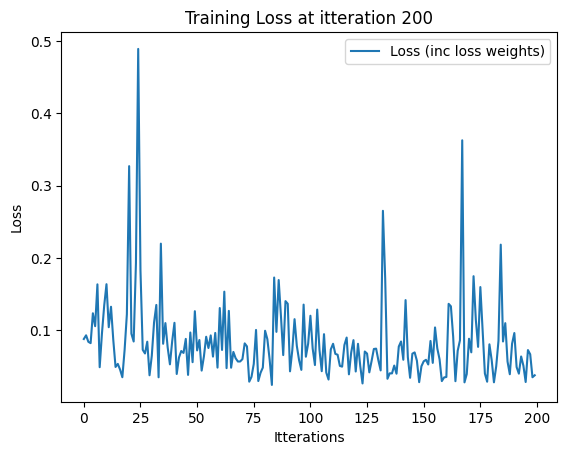

In [ ]:
dataset_bodies = PennFudanDataset(os.path.join(root,"PennFudanPed"))
model = full_object_detection_model(scales, ratios, dataset_bodies.unique_labels())

weights_file = "weights_body_detection"

if device == torch.device('cpu'):
  model.load_state_dict(torch.load(os.path.join(root, weights_file), map_location=torch.device('cpu')), strict=False)
else:
  model.load_state_dict(torch.load(os.path.join(root, weights_file)), strict=False)

# first:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# and than:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# I had to run this loop many times :(
losses = train_loop(model, dataset_bodies, optimizer, weights_file, batch_size=4, itterations=200)

Inference

In [ ]:
dataset_bodies = PennFudanDataset(os.path.join(root,"PennFudanPed"))
model = full_object_detection_model(scales, ratios, dataset_bodies.unique_labels())
model.to(device)
model.eval()

weights_file = "weights_body_detection"
if device == torch.device('cpu'):
  model.load_state_dict(torch.load(os.path.join(root, weights_file), map_location=torch.device('cpu')), strict=False)
else:
  model.load_state_dict(torch.load(os.path.join(root, weights_file)), strict=False)

for i in dataset_bodies.get_validation_idxs():
  image, GT_boxes, GT_labels = dataset_bodies.getitem(i)
  image = np.expand_dims(image.transpose(2, 0, 1), axis=0)

  y_anchor_points, x_anchor_points = gen_anchor_points(feature_space_size)
  anchor_boxes, complete_boxes_mask = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, len(image), feature_space_size)

  image = torch.from_numpy(image).to(dtype=torch.float32).to(device)
  preprocess = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  prepocessed_image = preprocess(image)
  anchor_boxes = torch.from_numpy(anchor_boxes).to(dtype=torch.float32).to(device)

  box_proposals_per_img, label_predictions_per_image = model.forward(prepocessed_image, anchor_boxes)
  proposed_boxes = box_proposals_per_img[0].cpu().numpy()
  proposed_labels = label_predictions_per_image[0].cpu().numpy().astype(int)

  print('ground truth:')
  plot_with_boxes(image.squeeze().cpu().numpy().transpose(1, 2, 0), GT_boxes, GT_labels, dataset_bodies)
  print('results:')
  plot_with_boxes(image.squeeze().cpu().numpy().transpose(1, 2, 0), change_size(proposed_boxes, feature_space_size, img_size), proposed_labels, dataset_bodies)

Output hidden; open in https://colab.research.google.com to view.

Other Dataset with faces :)

[[733.66013072 356.61764706 281.04575163 195.58823529]
 [316.99346405 451.47058824 294.11764706 205.88235294]
 [468.1372549  266.91176471 341.50326797 245.58823529]]
[1 1 1]


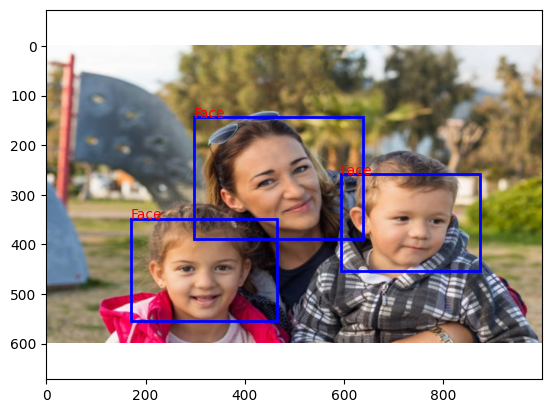

In [ ]:
class HumanFacesDataset():
    def __init__(self, root):
      self.root = root
      self.transform = transforms.Compose([transforms.Resize(img_size, antialias=True)])
      self.images = list(sorted(os.listdir(os.path.join(root, "images"))))

      self.boxes = pd.read_csv(os.path.join(root, "faces.csv"))
      self.max_objects = self.boxes.image_name.value_counts()[0].item()

      # you have to fill this in yourself with most datasets
      self.object_dict = { 0: 'background', 1: 'Face'}

    def getitem(self, idx):
      # load images and masks
      img_path = os.path.join(self.root, "images", self.images[idx])
      img = read_image(img_path)

      #the boxes
      boxes = self.boxes[self.boxes["image_name"] == self.images[idx]]
      boxes = boxes.drop('image_name', axis=1).drop('width', axis=1).drop('height', axis=1).to_numpy()

      # put the boxes in the right format [center_x, center_y, width, height]
      # and reshape the boxes to the new image size
      ratio_y = img_size[0] / img.shape[1]
      ratio_x = img_size[1] / img.shape[2]
      center_x = boxes[:,0] + 0.5*(boxes[:,2] - boxes[:,0])
      center_y = boxes[:,1] + 0.5*(boxes[:,3] - boxes[:,1])
      width = boxes[:,2] - boxes[:,0]
      height = boxes[:,3] - boxes[:,1]
      boxes = np.stack([center_x*ratio_x, center_y*ratio_y, width*ratio_x, height*ratio_y], axis = -1)

      # resize image with resize
      img = self.transform(img)
      img = np.array(img, dtype=np.uint8)/255
      img = img.transpose(1,2,0)

      # there is only one class/label
      labels = np.ones((boxes.shape[0]), dtype=np.int8)
      return img, boxes, labels

    def __len__(self):
      return len(self.images)

    def max_num_objects(self):
      return self.max_objects

    def get_label(self, int):
      if int > (len(self.object_dict)-1) | int < (len(self.object_dict)-1):
        return self.object_dict.get(0)
      return self.object_dict.get(int)

    def get_validation_idxs(self):
      return np.arange(0,220) #~10%

    def get_train_idxs(self):
      return np.arange(220,len(self.images))

    def unique_labels(self):
      return len(self.object_dict)

dataset_faces = HumanFacesDataset(os.path.join(root,"HumanFaces"))

img, gt_boxes, labels = dataset_faces.getitem(2100)
print(gt_boxes)
print(labels)
plot_with_boxes(img, gt_boxes, labels, dataset_faces)

confidence_loss: 0.039822
offset_loss: 0.061689
label_loss: 0.000000


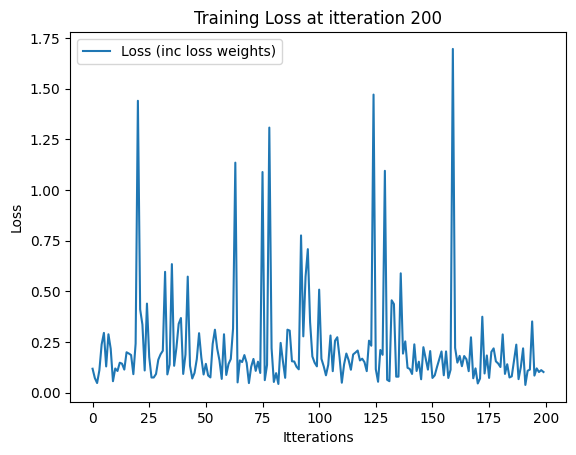

In [ ]:
dataset_faces = HumanFacesDataset(os.path.join(root,"HumanFaces"))
model = full_object_detection_model(scales, ratios, dataset_faces.unique_labels())
model.to(device)
weights_file = "weights_face_detection"


if device == torch.device('cpu'):
  model.load_state_dict(torch.load(os.path.join(root, weights_file), map_location=torch.device('cpu')), strict=True)
else:
  model.load_state_dict(torch.load(os.path.join(root, weights_file)), strict=False)

# first:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# and than (mant times):
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# I had to run this loop many times :(
losses = train_loop(model, dataset_faces, optimizer, weights_file, batch_size=4, itterations=200)

In [39]:
dataset_faces = HumanFacesDataset(os.path.join(root,"HumanFaces"))
model = full_object_detection_model(scales, ratios, dataset_faces.unique_labels())
model.to(device)
model.eval()


weights_file = "weights_face_detection"
if device == torch.device('cpu'):
  model.load_state_dict(torch.load(os.path.join(root, weights_file), map_location=torch.device('cpu')), strict=False)
else:
  model.load_state_dict(torch.load(os.path.join(root, weights_file)), strict=False)

for i in  np.random.choice(dataset_faces.get_validation_idxs(), 10):
  image, GT_boxes, GT_labels = dataset_faces.getitem(i)
  image = np.expand_dims(image.transpose(2, 0, 1), axis=0)

  y_anchor_points, x_anchor_points = gen_anchor_points(feature_space_size)
  anchor_boxes, complete_boxes_mask  = gen_anchor_boxes(y_anchor_points, x_anchor_points, scales, ratios, len(image), feature_space_size)

  image = torch.from_numpy(image).to(dtype=torch.float32).to(device)
  preprocess = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  prepocessed_image = preprocess(image)

  anchor_boxes = torch.from_numpy(anchor_boxes).to(dtype=torch.float32).to(device)

  box_proposals_per_img, label_predictions_per_image = model.forward(prepocessed_image, anchor_boxes)
  proposed_boxes = box_proposals_per_img[0].cpu().numpy()
  proposed_labels = label_predictions_per_image[0].cpu().numpy().astype(int)

  print('ground truth:')
  plot_with_boxes(image.squeeze().cpu().numpy().transpose(1, 2, 0), GT_boxes, GT_labels, dataset_faces)
  print('resuls:')
  plot_with_boxes(image.squeeze().cpu().numpy().transpose(1, 2, 0), change_size(proposed_boxes, feature_space_size, img_size), proposed_labels, dataset_faces)